In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from fbm_dropout.fbm_dropout import DropoutFBM

class DenseNetFBM(nn.Module):

    def __init__(self, hidden_sizes, n_agents, max_epoch, grid_sizes, device=None, dtype=None):

        super().__init__()
        
        self.linear_1 = nn.Linear(28*28, hidden_sizes[0], device=device, dtype=dtype)
        self.linear_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1], device=device, dtype=dtype)
        self.linear_3 = nn.Linear(hidden_sizes[1], 10, device=device, dtype=dtype)
        self.dropout_1 = DropoutFBM(0.8, n_agents[0], max_epoch, grid_sizes[0], show=False, device=device, dtype=dtype)
        self.dropout_2 = DropoutFBM(0.8, n_agents[1], max_epoch, grid_sizes[1], show=False, device=device, dtype=dtype)

    def forward(self, input, current_epoch):

        if self.training:
            output = F.relu(self.dropout_1(self.linear_1(input), current_epoch))
            output = F.relu(self.dropout_2(self.linear_2(output), current_epoch))
        else:
            output = F.relu(self.linear_1(input))
            output = F.relu(self.linear_2(output))
            
        output = self.linear_3(output)
        
        return output

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class DenseNet(nn.Module):

    def __init__(self, hidden_sizes, dropout_rate, device=None, dtype=None):

        super().__init__()
        
        self.linear_1 = nn.Linear(784, hidden_sizes[0], device=device, dtype=dtype)
        self.linear_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1], device=device, dtype=dtype)
        self.linear_3 = nn.Linear(hidden_sizes[1], 10, device=device, dtype=dtype)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input):

        output = F.relu(self.dropout(self.linear_1(input)))
        output = F.relu(self.dropout(self.linear_2(output)))
        output = self.linear_3(output)
        return output

In [4]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST('~/datasets', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/datasets', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
import torch.optim as optim

hidden_sizes = [256, 64]
max_epochs = 200
grid_sizes = [(16,16), (8,8)]
n_agents = [32, 8]
device='cuda'

model = DenseNet(hidden_sizes, 0, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_dropout = DenseNet(hidden_sizes, .2, device=device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)

model_fbm_dropout = DenseNetFBM(hidden_sizes, n_agents, max_epochs, grid_sizes, device=device)
optimizer_fbm_dropout = optim.Adam(model_fbm_dropout.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [6]:
results = {}
results['train loss'] = {}
results['train loss']['no dropout'] = []
results['train loss']['dropout'] = []
results['train loss']['fbm dropout'] = []
results['test acc'] = {}
results['test acc']['no dropout'] = []
results['test acc']['dropout'] = []
results['test acc']['fbm dropout'] = []
for epoch in range(max_epochs):
    model.train()
    model_dropout.train()
    model_fbm_dropout.train()

    running_loss = {}
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        optimizer_dropout.zero_grad()
        optimizer_fbm_dropout.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss['no dropout'] += loss.item()

        output_dropout = model_dropout(images)
        loss_dropout = criterion(output_dropout, labels)
        loss_dropout.backward()
        optimizer_dropout.step()
        running_loss['dropout'] += loss_dropout.item()

        output_fbm_dropout = model_fbm_dropout(images, epoch)
        loss_fbm_dropout = criterion(output_fbm_dropout, labels)
        loss_fbm_dropout.backward()
        optimizer_fbm_dropout.step()
        running_loss['fbm dropout'] += loss_fbm_dropout.item()

    results['train loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['train loss']['dropout'].append(running_loss['dropout'] / len(train_loader))
    results['train loss']['fbm dropout'].append(running_loss['fbm dropout'] / len(train_loader))

    model.eval()
    model_dropout.eval()
    model_fbm_dropout.eval()
    acc = acc_dropout = acc_fbm_dropout = 0.0
    for images, labels in test_loader:
        images = images.view(-1,784).to(device)
        labels = labels.to(device)
        output = model(images)
        _, pred = torch.max(output, axis=1)
        acc += torch.sum(pred==labels).item()

        output_dropout = model_dropout(images)
        _, pred_dropout = torch.max(output_dropout, axis=1)
        acc_dropout += torch.sum(pred_dropout==labels).item()

        output_fbm_dropout = model_fbm_dropout(images, epoch)
        _, pred_fbm_dropout = torch.max(output_fbm_dropout, axis=1)
        acc_fbm_dropout += torch.sum(pred_fbm_dropout==labels).item()
    
    results['test acc']['no dropout'].append(acc / len(testset))
    results['test acc']['dropout'].append(acc_dropout / len(testset))
    results['test acc']['fbm dropout'].append(acc_fbm_dropout / len(testset))

    
    print('Epoch {}'.format(epoch))
    print('No Dropout : Train Loss {:.2f}, Test Acc {:.2f}'.format(results['train loss']['no dropout'][-1], results['test acc']['no dropout'][-1]))
    print('Dropout    : Train Loss {:.2f}, Test Acc {:.2f}'.format(results['train loss']['dropout'][-1], results['test acc']['dropout'][-1]))
    print('FBM Dropout: Train Loss {:.2f}, Test Acc {:.2f}'.format(results['train loss']['fbm dropout'][-1], results['test acc']['fbm dropout'][-1]))

Epoch 0
No Dropout : Train Loss 0.37, Test Acc 0.94
Dropout    : Train Loss 0.44, Test Acc 0.94
FBM Dropout: Train Loss 0.40, Test Acc 0.93
Epoch 1
No Dropout : Train Loss 0.17, Test Acc 0.96
Dropout    : Train Loss 0.22, Test Acc 0.96
FBM Dropout: Train Loss 0.21, Test Acc 0.94
Epoch 2
No Dropout : Train Loss 0.12, Test Acc 0.97
Dropout    : Train Loss 0.17, Test Acc 0.96
FBM Dropout: Train Loss 0.16, Test Acc 0.94
Epoch 3
No Dropout : Train Loss 0.10, Test Acc 0.97
Dropout    : Train Loss 0.15, Test Acc 0.97
FBM Dropout: Train Loss 0.14, Test Acc 0.95
Epoch 4
No Dropout : Train Loss 0.08, Test Acc 0.97
Dropout    : Train Loss 0.13, Test Acc 0.97
FBM Dropout: Train Loss 0.12, Test Acc 0.96
Epoch 5
No Dropout : Train Loss 0.07, Test Acc 0.97
Dropout    : Train Loss 0.12, Test Acc 0.97
FBM Dropout: Train Loss 0.11, Test Acc 0.92
Epoch 6
No Dropout : Train Loss 0.06, Test Acc 0.97
Dropout    : Train Loss 0.12, Test Acc 0.97
FBM Dropout: Train Loss 0.10, Test Acc 0.95
Epoch 7
No Dropout :

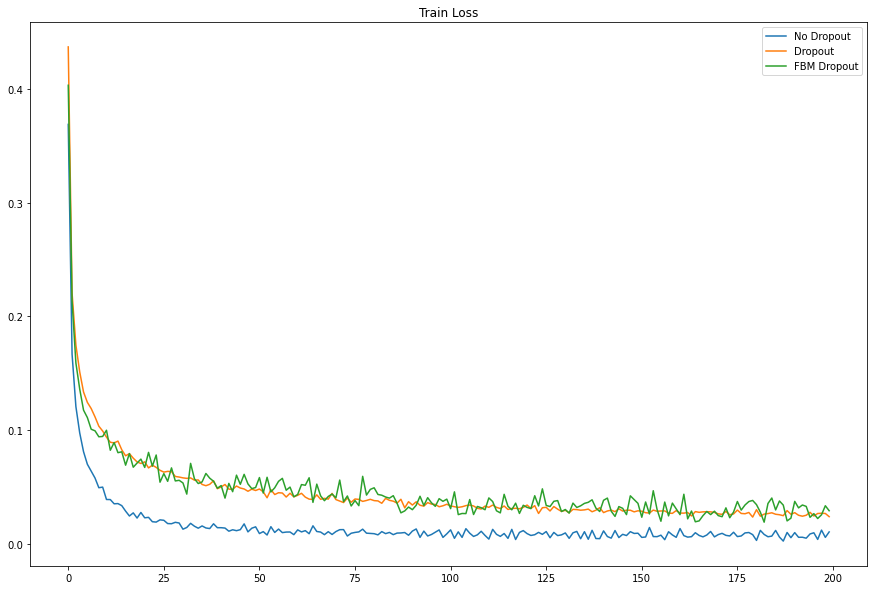

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(results['train loss']['no dropout'], label='No Dropout')
plt.plot(results['train loss']['dropout'], label='Dropout')
plt.plot(results['train loss']['fbm dropout'], label='FBM Dropout')
plt.title('Train Loss')
plt.legend()
plt.show()

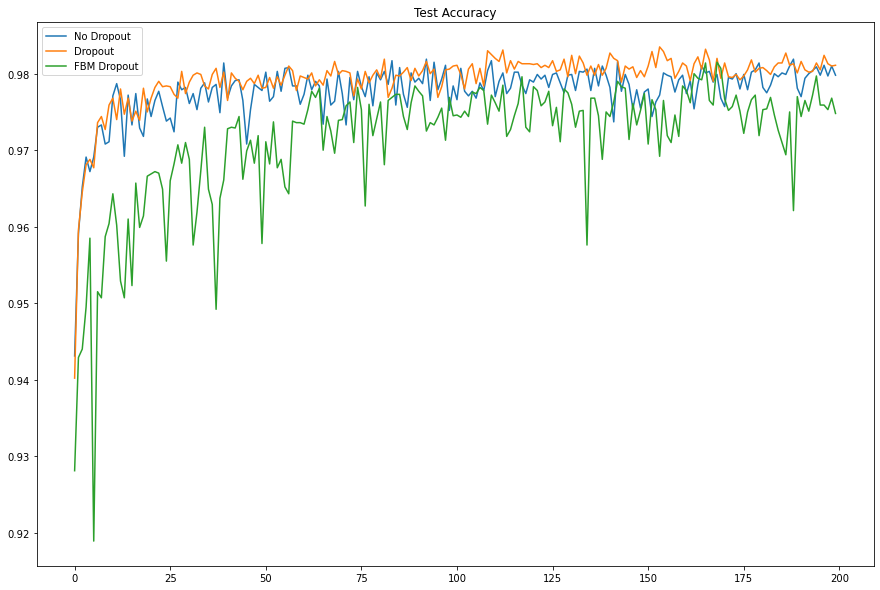

In [8]:
plt.figure(figsize=(15,10))
plt.plot(results['test acc']['no dropout'], label='No Dropout')
plt.plot(results['test acc']['dropout'], label='Dropout')
plt.plot(results['test acc']['fbm dropout'], label='FBM Dropout')
plt.title('Test Accuracy')
plt.legend()
plt.show()